In [218]:
import pandas as pd, xarray as xr, numpy as np, matplotlib.pyplot as plt, sklearn as sk, scipy

In [248]:
#Load in feature and label data
features = pd.read_csv('C:/users/benja/downloads/ORIE4741/all_feature_data.csv')
labels = pd.read_csv('C:/users/benja/downloads/ORIE4741/all_label_data.csv')
features = features.drop(columns = ['Unnamed: 0'])
labels = labels.drop(columns = ['Unnamed: 0'])

In [221]:
#Remove data points with more than half of features missing
dropidxs = []
for i in range(features.shape[0]):
  if pd.isnull(features).sum(axis = 1)[i] > 0.5*features.shape[1]:
    dropidxs.append(i)
print('Dropping ' + str(len(dropidxs)) + ' data points due to missing data')

features = features.drop(index = dropidxs).reset_index(drop=True)
labels = labels.drop(index = dropidxs).reset_index(drop=True)

Dropping 67 data points due to missing data


In [222]:
from numpy import random
#Set random seed for reproducible results
np.random.seed(1)

In [226]:
#Randomly select indices for training and testing data

other_indices = []
test_indices = []
validate_indices = []
train_indices = []

while len(train_indices) < int(np.round(features.shape[0] * 0.5)):
  i = np.random.randint(0, features.shape[0])
  if i not in train_indices:
    train_indices.append(i)

for i in range(features.shape[0]):
  if i not in train_indices:
    other_indices.append(i)

while len(validate_indices) < int(np.round(len(other_indices) * 0.6)):
  i = np.random.randint(0, len(other_indices))
  if other_indices[i] not in validate_indices:
    validate_indices.append(other_indices[i])

for i in range(len(other_indices)):
  if other_indices[i] not in validate_indices:
    test_indices.append(other_indices[i])


train_indices = np.array(train_indices)
validate_indices = np.array(validate_indices)
test_indices = np.array(test_indices)

In [227]:
#Split into training and testing features and labels
training_features_array = features.iloc[train_indices].values
training_labels_array = labels.iloc[train_indices, 1:].values
validate_features_array = features.iloc[validate_indices].values
validate_labels_array = labels.iloc[validate_indices, 1:].values
testing_features_array = features.iloc[test_indices].values
testing_labels_array = labels.iloc[test_indices, 1:].values

from sklearn.preprocessing import StandardScaler
all_features_array_scaled = StandardScaler().fit(np.array(features)).transform(np.array(features))

training_features_array_scaled = all_features_array_scaled[train_indices, :]
validate_features_array_scaled = all_features_array_scaled[validate_indices, :]
testing_features_array_scaled = all_features_array_scaled[test_indices, :]

<Axes: >

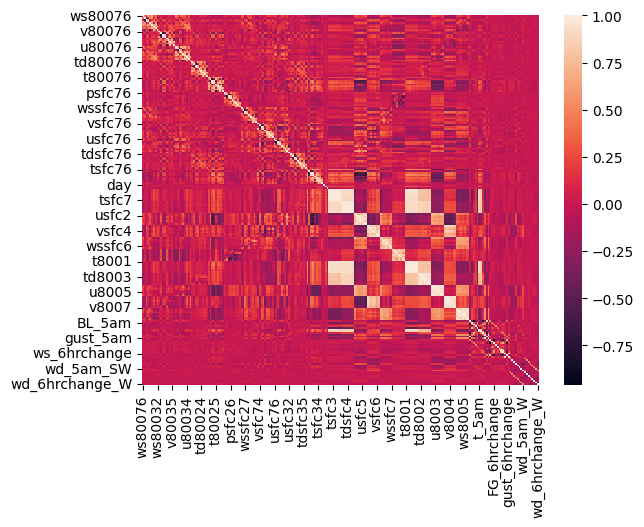

In [229]:
import seaborn as sns
sns.heatmap(features.corr())

Ridge regression with all features

0.4234756849429345


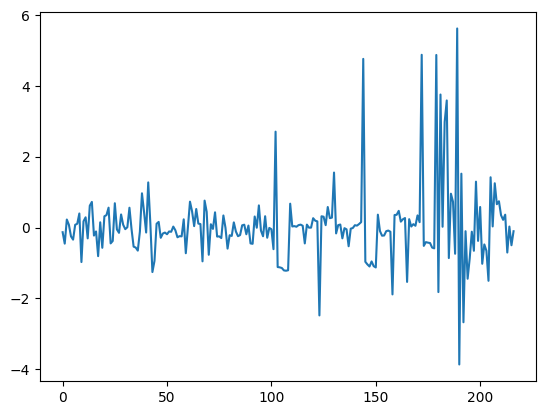

In [230]:
from sklearn.linear_model import Ridge

alpha_value = 1
rr = Ridge(alpha = alpha_value)
rr.fit(training_features_array_scaled, training_labels_array[:, 0])
print(rr.score(testing_features_array_scaled, testing_labels_array[:, 0]))
plt.plot(range(len(rr.coef_)), rr.coef_)


In [231]:
from sklearn.model_selection import cross_val_score
cross_val_score(rr, training_features_array_scaled, training_labels_array[:, 0], scoring = 'neg_mean_squared_error')

array([-168.46725752, -169.4190573 , -201.66321548, -157.73942577,
       -160.86344716])

Linear model fit to all features of training data

In [232]:

from sklearn.linear_model import LinearRegression
linreg = LinearRegression().fit(training_features_array_scaled, training_labels_array[:, 0])


In [233]:
predictions = linreg.predict(testing_features_array_scaled)

In [234]:
linreg.score(testing_features_array_scaled, testing_labels_array[:,0])

0.4211907375570175

Text(0.5, 1.0, 'Linear Regression, no normalization, all features')

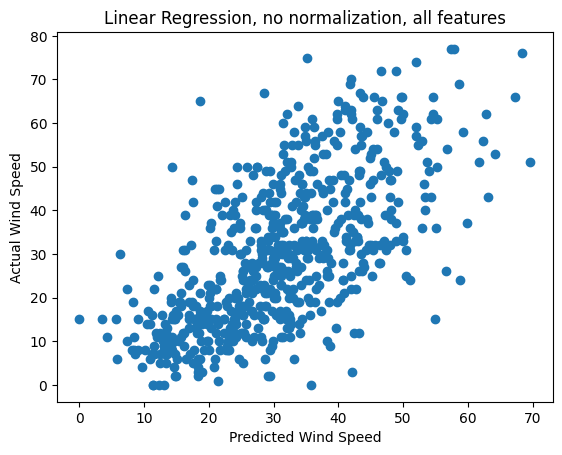

In [235]:
plt.scatter(predictions, testing_labels_array[:, 0])
plt.xlabel('Predicted Wind Speed')
plt.ylabel('Actual Wind Speed')
plt.title('Linear Regression, no normalization, all features')

In [182]:
from sklearn.model_selection import cross_val_score
cross_val_score(linreg, training_features_array_scaled, training_labels_array[:, 0], scoring = 'neg_mean_squared_error')

array([-50.32449581, -38.49682651, -36.60952639, -50.38391233,
       -46.97260372])

Simple decision tree fit to all features of training data

In [197]:
from sklearn.tree import DecisionTreeRegressor

Text(0.5, 1.0, 'Parameter tuning for decision tree')

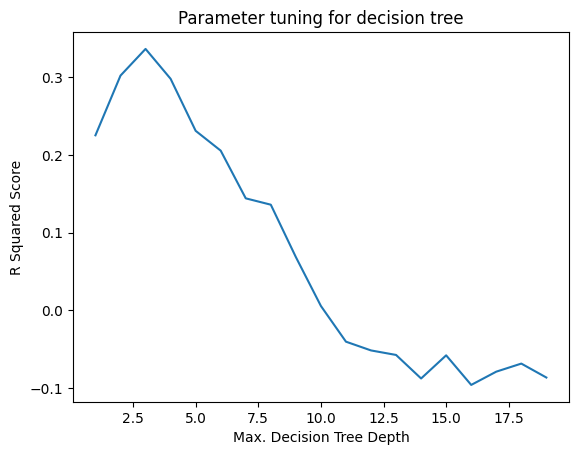

In [236]:
scores = []
for maxdepth in range(1, 20):
  dt = DecisionTreeRegressor(max_depth = maxdepth).fit(training_features_array, training_labels_array[:, 0])
  scores.append(dt.score(validate_features_array, validate_labels_array[:, 0]))

plt.plot(np.arange(1, 20), scores)
plt.xlabel('Max. Decision Tree Depth')
plt.ylabel('R Squared Score')
plt.title('Parameter tuning for decision tree')

In [189]:
#Make decision tree of optimal depth
dt = DecisionTreeRegressor(max_depth = 5).fit(training_features_array_scaled, training_labels_array[:, 0])

In [192]:
dtpredictions = dt.predict(testing_features_array_scaled)

Text(0.5, 1.0, 'Decision Tree Regressor trained on all features \n max_depth = 5')

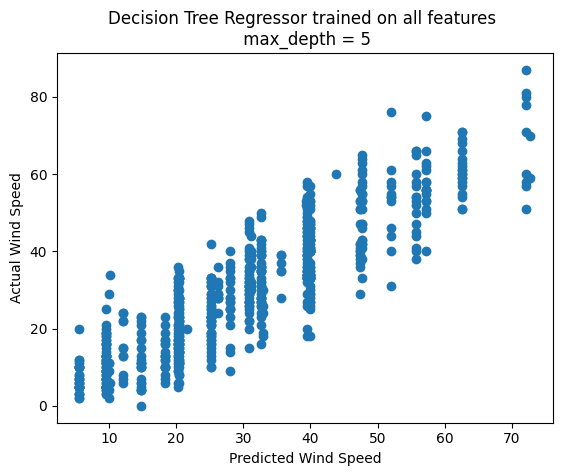

In [193]:
plt.scatter(dtpredictions, testing_labels_array[:, 0])
plt.xlabel('Predicted Wind Speed')
plt.ylabel('Actual Wind Speed')
plt.title('Decision Tree Regressor trained on all features \n max_depth = 5')

In [46]:
#Visualize tree
import graphviz
from sklearn.tree import export_graphviz

def draw_tree(tree):
    dot_data = export_graphviz(tree, out_file=None, 
                         filled=True, 
                         feature_names = training_features.columns,
                         #impurity=True,
                         rounded=True,  
                         special_characters=True,
                              proportion = True)
    
    graph = graphviz.Source(dot_data)
    graph.format = 'png'
    graph.render('tree',view=True)

draw_tree(dt)

What about if we use the single best predictor (ws8001)?

(0.0, 90.0)

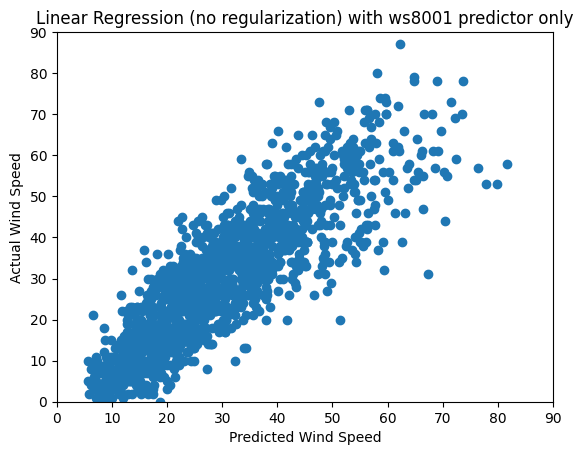

In [238]:
from sklearn.metrics import r2_score

#Plot lin reg result
#Note some pretty significant errors at higher wind speeds (could look into why these are happening, if we can improve in this area)
lr_onepredictor = LinearRegression().fit(training_features['ws8001'].values.reshape(-1, 1), training_labels['sknt'].values)
predictions_onepred = lr_onepredictor.predict(testing_features['ws8001'].values.reshape(-1, 1))
lr_onepredictor.score(testing_features['ws8001'].values.reshape(-1, 1), testing_labels['sknt'].values)
plt.scatter(predictions_onepred, testing_labels['sknt'])
plt.ylabel('Actual Wind Speed')
plt.xlabel('Predicted Wind Speed')
plt.title('Linear Regression (no regularization) with ws8001 predictor only')
plt.xlim([0, 90])
plt.ylim([0, 90])

What if we only look at winds greater than 40 kt?

In [50]:
#Get only winds above 40mph from training and testing data
g40_training_features = training_features[training_labels['sknt'] > 40]
g40_training_labels = training_labels[training_labels['sknt'] > 40]
g40_testing_features = testing_features[testing_labels['sknt'] > 40]
g40_testing_labels = testing_labels[testing_labels['sknt'] > 40]

In [51]:
from sklearn.metrics import r2_score

#Print score for regression using just ws8001 predictor
lr_g40 = LinearRegression().fit(g40_training_features['ws8001'].values.reshape(-1, 1), g40_training_labels['sknt'].values)
predictions_g40 = lr_g40.predict(g40_testing_features['ws8001'].values.reshape(-1, 1))
lr_g40.score(g40_testing_features['ws8001'].values.reshape(-1, 1), g40_testing_labels['sknt'].values)

0.3644258303665877

Text(0.5, 1.0, 'Linear Regression (no regularization) \n only ws8001 predictor used \n only for 40kt+ wind speeds')

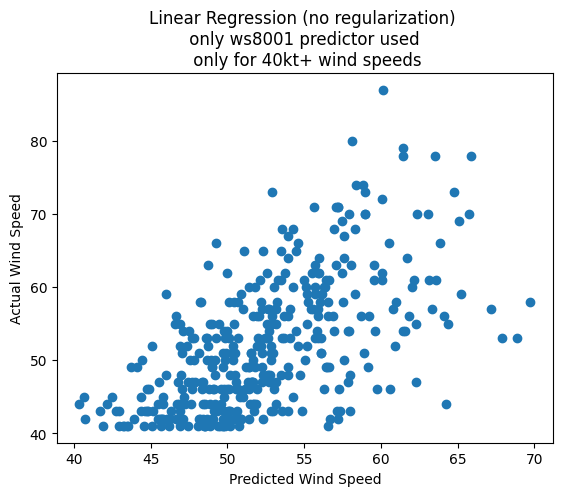

In [53]:
plt.scatter(predictions_g40, g40_testing_labels['sknt'].values)
plt.xlabel('Predicted Wind Speed')
plt.ylabel('Actual Wind Speed')
plt.title('Linear Regression (no regularization) \n only ws8001 predictor used \n only for 40kt+ wind speeds')

In [54]:
from sklearn.metrics import r2_score

#Redo regression for 40kt+ but use all predictors (worse?? score, why)
#Maybe regularizarion could help here. Tune regularization parameter later.
lr_g40_mp = LinearRegression().fit(g40_training_features.values, g40_training_labels['sknt'].values)
predictions_g40_mp = lr_g40_mp.predict(g40_testing_features.values)
lr_g40_mp.score(g40_testing_features.values, g40_testing_labels['sknt'].values)

0.30246098158251544

Text(0.5, 1.0, 'Linear Regression (no regularization) \n all predictors used \n only for 40kt+ wind speeds')

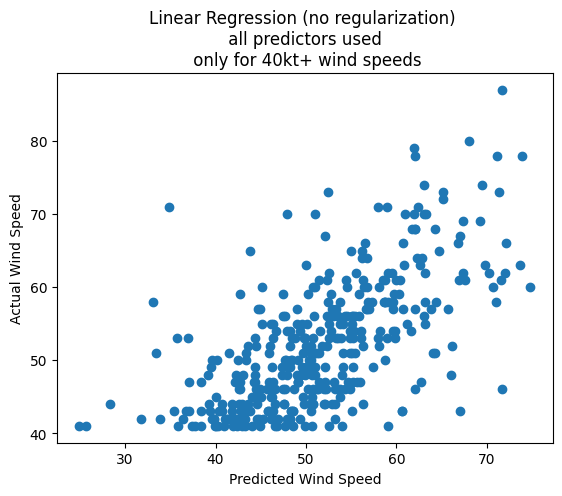

In [55]:
plt.scatter(predictions_g40_mp, g40_testing_labels['sknt'].values)
plt.xlabel('Predicted Wind Speed')
plt.ylabel('Actual Wind Speed')
plt.title('Linear Regression (no regularization) \n all predictors used \n only for 40kt+ wind speeds')